## Install Necessary Libraries

## Create Data Directories

In [1]:
# Install standard libraries for machine learning and web demos
%pip install transformers accelerate bitsandbytes gradio opencv-python -q

# Install the main diffusers library
%pip install git+https://github.com/huggingface/diffusers -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 MB 12.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
# Download the official LoRA training script from Hugging Face's repository
!wget https://raw.githubusercontent.com/huggingface/diffusers/main/examples/dreambooth/train_dreambooth_lora.py

# Create a folder to hold the original, raw photos you will upload
!mkdir /content/original_photos

# Create a folder to store the processed, 512x512 square-cropped photos
!mkdir /content/processed_dataset

print("Directories '/content/original_photos' and '/content/processed_dataset' created.")
print("Please upload your ~10-15 source images to '/content/original_photos' now.")


--2025-10-21 20:13:21--  https://raw.githubusercontent.com/huggingface/diffusers/main/examples/dreambooth/train_dreambooth_lora.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 59191 (58K) [text/plain]
Saving to: ‘train_dreambooth_lora.py’

train_dreambooth_lo 100%[===================>]  57.80K  --.-KB/s    in 0.002s  

2025-10-21 20:13:21 (25.6 MB/s) - ‘train_dreambooth_lora.py’ saved [59191/59191]

Directories '/content/original_photos' and '/content/processed_dataset' created.
Please upload your ~10-15 source images to '/content/original_photos' now.


## Preprocess The Data With OpenCV

In [3]:
import cv2
import os
import numpy as np

# Download the pre-trained face detection model from OpenCV
# This is a Haar Cascade model, a classic computer vision tool.
!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml

# Load the face cascade classifier
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

# Define our folder paths
input_dir = '/content/original_photos/'
output_dir = '/content/processed_dataset/'
target_size = 512 # The required resolution for Stable Diffusion v1.5

# Run over every file in the input directory
for filename in os.listdir(input_dir):
    # Check if the file is an image
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        file_path = os.path.join(input_dir, filename)

        # Read the image using OpenCV
        img = cv2.imread(file_path)

        if img is None:
            print(f"Warning: Could not read {filename}, skipping.")
            continue

        # Convert the image to grayscale (face detection works better on grayscale)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Detect faces in the image
        # detectMultiScale returns a list of (x, y, w, h) rectangles
        faces = face_cascade.detectMultiScale(gray, 1.3, 5)

        if len(faces) == 0:
            print(f"Warning: No face found in {filename}, skipping.")
            continue

        # Take the first face found (usually the largest one)
        (x, y, w, h) = faces[0]

        # Create a square crop around the face
        # Find the center of the face
        center_x = x + w // 2
        center_y = y + h // 2

        # Find the longest sideto make a square
        side_length = max(w, h)

        # Calculate the top-left corner of the square
        # Add a little padding (e.g., 20% more) to include forehead/chin
        padded_side = int(side_length * 1.2)
        x1 = max(0, center_x - padded_side // 2)
        y1 = max(0, center_y - padded_side // 2)

        # Calculate the bottom-right corner
        x2 = x1 + padded_side
        y2 = y1 + padded_side

        # Ensure the crop is within the image boundaries
        if x2 > img.shape[1]:
            x2 = img.shape[1]
            x1 = x2 - padded_side
        if y2 > img.shape[0]:
            y2 = img.shape[0]
            y1 = y2 - padded_side

        # Perform the crop
        cropped_face = img[y1:y2, x1:x2]

        # Resize the square crop to our target size (512x512)
        resized_face = cv2.resize(
            cropped_face,
            (target_size, target_size),
            interpolation=cv2.INTER_AREA
        )

        # Save the processed image to the output directory
        output_filename = os.path.join(output_dir, filename)
        cv2.imwrite(output_filename, resized_face)
        print(f"Processed: {filename} -> {output_filename}")

--2025-10-21 20:14:33--  https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 930127 (908K) [text/plain]
Saving to: ‘haarcascade_frontalface_default.xml’

haarcascade_frontal 100%[===================>] 908.33K  --.-KB/s    in 0.006s  

2025-10-21 20:14:33 (157 MB/s) - ‘haarcascade_frontalface_default.xml’ saved [930127/930127]

Processed: anil6.jpg -> /content/processed_dataset/anil6.jpg
Processed: anil1.jpeg -> /content/processed_dataset/anil1.jpeg
Processed: anil3.jpg -> /content/processed_dataset/anil3.jpg
Processed: anil5.jpg -> /content/processed_dataset/anil5.jpg
Processed: anil7.jpg -> /content/processed_dataset/anil7.jpg
Processed: anil4.jpg -> /co

## LoRA Training

In [4]:
import os
# Training Parameters

# The base model we are fine-tuning
PRETRAINED_MODEL = "runwayml/stable-diffusion-v1-5"

# The directory with our processed, 512x512 training images
INSTANCE_DATA_DIR = "/content/processed_dataset"

# The directory to save the trained LoRA file
OUTPUT_DIR = "/content/art_lora_model"

# The trigger word.
TRIGGER_WORD = "q1w2e3_person"

# Find the number processed photos
num_images = len([f for f in os.listdir(INSTANCE_DATA_DIR)
                  if f.endswith('.jpg') or f.endswith('.jpeg') or f.endswith('.png')])

num_epochs = 100

# Set the maximum trainning steps dynamically
MAX_TRAIN_STEPS = num_images * num_epochs


#The main command that starts the training process
!accelerate launch train_dreambooth_lora.py \
  --pretrained_model_name_or_path=$PRETRAINED_MODEL \
  --instance_data_dir=$INSTANCE_DATA_DIR \
  --output_dir=$OUTPUT_DIR \
  --instance_prompt="a photo of $TRIGGER_WORD" \
  --resolution=512 \
  --train_batch_size=1 \
  --gradient_accumulation_steps=1 \
  --checkpointing_steps=250 \
  --learning_rate=1e-4 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --max_train_steps=$MAX_TRAIN_STEPS \
  --mixed_precision="fp16" \
  --seed=42 \
  --use_8bit_adam

print("Training complete!")
print(f"The trained LoRA model is saved in: {OUTPUT_DIR}")

The following values were not passed to `accelerate launch` and had defaults used instead:
	`--num_processes` was set to a value of `1`
	`--num_machines` was set to a value of `1`
	`--mixed_precision` was set to a value of `'no'`
	`--dynamo_backend` was set to a value of `'no'`
To avoid this warning pass in values for each of the problematic parameters or run `accelerate config`.
2025-10-21 20:15:09.286002: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761077709.306017    1668 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761077709.311964    1668 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1761077709.327205    1668 computation_plac

## Test The Trained Model

In [5]:
import torch
from diffusers import StableDiffusionPipeline
from IPython.display import display

# The base model ID
model_id = "runwayml/stable-diffusion-v1-5"

# The path to our trained LoRA file.
# The script saves it inside the output_dir.
lora_path = "/content/art_lora_model/pytorch_lora_weights.safetensors"

TRIGGER_WORD = "q1w2e3_person"


# Load the base model in float16 precision for faster inference
pipe = StableDiffusionPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16
).to("cuda")

# Load our custom LoRA weights on top of the base model
pipe.load_lora_weights(lora_path)

print("Models loaded and ready!")


Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!
No LoRA keys associated to CLIPTextModel found with the prefix='text_encoder'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new


Models loaded and ready!


## Generate An Image

Generating image with prompt: 'q1w2e3_person as a Pixar character'


  0%|          | 0/60 [00:00<?, ?it/s]

Generation complete!


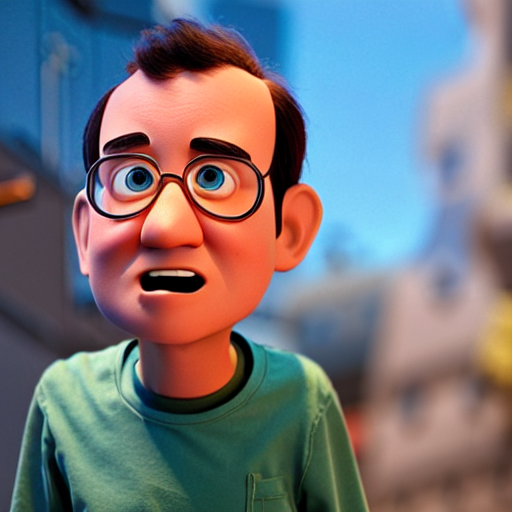

Image saved as 'my_first_avatar.png'


In [14]:
# Define the style
style = "as a Pixar character"
# style = "as a viking warrior"
# style = "as a character from The Simpsons"

# Combine the trigger word and the style into a final prompt
prompt = f"{TRIGGER_WORD} {style}"

print(f"Generating image with prompt: '{prompt}'")

# guidance_scale tells the model how strictly to follow the prompt
image = pipe(prompt, num_inference_steps=60, guidance_scale=7.5).images[0]

print("Generation complete!")

# Display the image in the Colab output cell
display(image)

# Save the image to the Colab disk
image.save("my_first_avatar.png")
print("Image saved as 'my_first_avatar.png'")

## Gradio Interface

In [15]:
import torch
from diffusers import StableDiffusionPipeline
import gradio as gr
import os

model_id = "runwayml/stable-diffusion-v1-5"

lora_path = "/content/art_lora_model/pytorch_lora_weights.safetensors"

TRIGGER_WORD = "q1w2e3_person"

pipe = StableDiffusionPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16
).to("cuda")

pipe.load_lora_weights(lora_path)

print("Models loaded onto GPU and ready!")


def generate_avatar(style_prompt):
    full_prompt = f"{TRIGGER_WORD} {style_prompt}"

    print(f"Generating... Prompt: '{full_prompt}'")

    image = pipe(
        full_prompt,
        num_inference_steps=60,
        guidance_scale=7.5
    ).images[0]

    return image


# Create a Gradio interface
with gr.Blocks() as demo:
    gr.Markdown("Art-LoRA Project")
    gr.Markdown(
        f"This demo showcases a LoRA-trained version of Stable Diffusion v1.5, "
        "fine-tuned on the face of '{TRIGGER_WORD}'."
    )

    with gr.Row():
        with gr.Column():
            style_input = gr.Textbox(
                label="Enter the style you want",
                placeholder="e.g. as a Pixar character, high quality, 8k"
            )
            submit_btn = gr.Button("Generate")

        with gr.Column():
            image_output = gr.Image(label="Generated Avatar")

    submit_btn.click(fn=generate_avatar, inputs=style_input, outputs=image_output)

demo.launch(share=True, debug=True)


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

No LoRA keys associated to CLIPTextModel found with the prefix='text_encoder'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new


Models loaded onto GPU and ready!
Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://60a794110b1b02a387.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Generating... Prompt: 'q1w2e3_person as a samurai warrior'


  0%|          | 0/60 [00:00<?, ?it/s]

Generating... Prompt: 'q1w2e3_person as a samurai warrior'


  0%|          | 0/60 [00:00<?, ?it/s]

Generating... Prompt: 'q1w2e3_person as a samurai warrior with no glasses'


  0%|          | 0/60 [00:00<?, ?it/s]

Generating... Prompt: 'q1w2e3_person as a samurai warrior with no glasses'


  0%|          | 0/60 [00:00<?, ?it/s]

Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://60a794110b1b02a387.gradio.live
